## logistic regression model

#### import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### load cleaned feature data table

In [2]:
df = pd.read_feather('../data/processed/df_to_model_labs')

In [3]:
df.columns

Index(['time_on_vent', 'anchor_age', 'spontrr', 'heartrate', 'std_spontrr',
       'weight', 'sodium', 'abg_po2', 'abg_ph', 'hco3', 'abg_pco2',
       'bloodpressure', 'std_pulseox', 'std_heartrate', 'creatinine', 'bun',
       'height', 'lactic_acid', 'hemoglobin', 'wbg', 'tidalvolume', 'temp',
       'std_bloodpressure', 'pulseox', 're_intub_class', 'gender',
       'admission_type', 'tidal_weight'],
      dtype='object')

## Handle categoricals

In [4]:
X = df[df.columns.drop('re_intub_class')]
y = df['re_intub_class']

In [5]:
# Import libraries 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [6]:
numeric_features  = df[df.columns.drop(['gender','admission_type','re_intub_class'])].columns
numeric_transformer = Pipeline(steps=[
   # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = df[['gender','admission_type']].columns
categorical_transformer = Pipeline(steps=[
   # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop = 'first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 101)

In [12]:
scaled_train = preprocessor.fit_transform(X_train)

In [13]:
scaled_test = preprocessor.transform(X_test) 

In [14]:
oversample = SMOTE(random_state = 101)
X_smote, y_smote = oversample.fit_resample(scaled_train, y_train)

In [15]:
param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']},]

rfc_param_grid=[
    {'n_estimators' : list(range(10,101,10)),
    'max_features' : list(range(6,32,5))}]

svc_param_grid ={ 'kernel':('linear', 'rbf'), 
                 'C': [0.1,1, 10, 100, 1000], 
                 'gamma': [1,0.1,0.01,0.001,0.0001]}

In [16]:
clf = GridSearchCV(LogisticRegression(),param_grid,refit=True)
clf.fit(X_smote,y_smote)

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}])

In [24]:
import statsmodels.api as sm

In [25]:
logit_model=sm.Logit(y_smote,X_smote)
result=logit_model.fit()
print(result.summary(alpha = 0.05))

Optimization terminated successfully.
         Current function value: 0.650467
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         re_intub_class   No. Observations:                 8750
Model:                          Logit   Df Residuals:                     8720
Method:                           MLE   Df Model:                           29
Date:                Thu, 01 Oct 2020   Pseudo R-squ.:                 0.06157
Time:                        12:20:36   Log-Likelihood:                -5691.6
converged:                       True   LL-Null:                       -6065.0
Covariance Type:            nonrobust   LLR p-value:                1.544e-138
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3607      0.032     11.307      0.000       0.298       0.423
x2             0.0918      0.

In [ ]:
result.params

In [17]:
clf.best_estimator_.coef_

array([[ 0.35434602,  0.08773819, -0.01255855,  0.15239395, -0.00408118,
        -0.14762836, -0.02667417,  0.        , -0.03902496, -0.14056236,
         0.06268737, -0.04545993,  0.05966019,  0.15312111, -0.18972059,
         0.27124806,  0.10217171,  0.02240377, -0.0333273 ,  0.01595145,
        -0.17382604,  0.1516572 ,  0.07116058,  0.01171731,  0.        ,
        -0.02514667, -0.4802877 ,  0.19417603, -0.35163425,  0.        ]])

In [18]:
clf.best_estimator_

LogisticRegression(C=0.23357214690901212, penalty='l1', solver='liblinear')

In [20]:
predictions = clf.predict(scaled_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
tn, fp, fn, tp

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1107
           1       0.13      0.57      0.21       114

    accuracy                           0.61      1221
   macro avg       0.53      0.59      0.47      1221
weighted avg       0.86      0.61      0.69      1221

[[674 433]
 [ 49  65]]


(674, 433, 49, 65)

In [ ]:
clf.predict_log_proba(X_test)

In [21]:
train_predictions = clf.predict(scaled_train)
print(classification_report(y_train,train_predictions))
print(confusion_matrix(y_train,train_predictions))

              precision    recall  f1-score   support

           0       0.93      0.60      0.73      4375
           1       0.15      0.60      0.24       507

    accuracy                           0.60      4882
   macro avg       0.54      0.60      0.48      4882
weighted avg       0.85      0.60      0.68      4882

[[2621 1754]
 [ 201  306]]


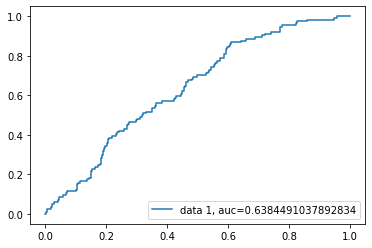

In [23]:
y_pred_proba = clf.predict_proba(scaled_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### 5. Evaulate model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
print(confusion_matrix(y_test,predictions))

In [ ]:
import joblib

In [ ]:
#joblib.dump(clf, "reintubate_model_log.sav")

In [ ]:
#joblib.dump(scaler, "reintubate_scaler.sav")

## Train model

### perform train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 3. SMOTE IT!

from collections import Counter
counter = Counter(y_train)
print(counter)

# transform the dataset
oversample = SMOTE(random_state = 101)

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

counter = Counter(y_smote)
print(counter)

#### 4. Do logistic regression model

from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=1000, C=0.0001)
logmodel.fit(X_smote,y_smote)

import pickle

In [ ]:
# Save the model as a pickle in a file 
#pickle.dump(logmodel, open("reintubate_model_log", 'wb')) 

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features  = df[df.columns.drop(['gender','admission_type','re_intub_class'])].columns
#numeric_transformer = ('scaler', StandardScaler())
numeric_transformer = make_column_transformer(
    (StandardScaler(), numeric_features),
    remainder='passthrough')


categorical_features = df[['gender','admission_type']].columns
#categorical_transformer =  ('onehot', OneHotEncoder(drop='first'))
categorical_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_features),
    remainder='passthrough')

#preprocessor = make_column_transformer(
 #   transformers=[
  #      ('num', numeric_transformer, numeric_features),
   #     ('cat', categorical_transformer, categorical_features)],
#remainder ='passthrough')

clf = Pipeline(steps=[('num', numeric_transformer),
                      ('cat', categorical_transformer),
                      ('classifier', LogisticRegression())])

#### 2. Perform feature scaling

Because the range of values in the features are not necessarily in the same order of magnitude, we will scale the feature data prior to training the model.

* actually... they might not be far off! 

mask=['spontRR', 'stdABP', 'meanABP', 'stdSpontRR', 'pulseox', 'stdPulseox',
       'temp', 'heartRate', 'stdHeartRate', 'weight', 'height', 'anchor_age',
       'time_on_vent']

X_traina = X_train.copy()
X_testa = X_test.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.loc[:,mask])
X_traina.loc[:,mask] = scaler.transform(X_train.loc[:,mask])

#X_train = scaler.transform(X_train)
X_testa.loc[:,mask] = scaler.transform(X_test.loc[:,mask])